# **Sentence Segmentation**

**Segmentacija rečenica (Sentence segmentation)** je proces razdvajanja neprekidnog teksta na pojedinačne rečenice, pri čemu se definiraju točne granice svake rečenice unutar teksta. To je jedan od osnovnih koraka u obradi prirodnog jezika (NLP – Natural Language Processing), jer većina jezičnih analiza, poput parsiranja, prepoznavanja entiteta ili sažimanja teksta, zahtijeva jasno strukturirane rečenice.


In [ ]:
!pip install nltk sklearn-crfsuite

import nltk
nltk.download('punkt_tab')

import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import re

from nltk.tokenize import word_tokenize

import sklearn
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction import DictVectorizer
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix
from sklearn.tree import DecisionTreeClassifier
import sklearn_crfsuite

import joblib
import numpy as np
import tensorflow as tf

from tensorflow.keras.layers import Embedding, GRU, Dense, Dropout, TimeDistributed
from tensorflow.keras.models import Sequential
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import to_categorical

[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!


**1. Priprema podataka**

Za razdvajanje teksta na pojedinačne rečenice koriste se automatizirane metode segmentacije temeljene na regularnim izrazima za identifikaciju granica rečenica, uzimajući u obzir interpunkcijske znakove i specifične slučajeve poput skraćenica. Nakon toga, primjenjuju se metode čišćenja teksta, uključujući uklanjanje stop riječi, kako bi se dobile pripremljene rečenice za daljnju analizu.

In [ ]:
from google.colab import drive
drive.mount('/content/drive')
%cd /content/drive/MyDrive/projekt_nlp

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
/content/drive/MyDrive/projekt_nlp


In [ ]:
# Učitavanje stop riječi
with open('/content/drive/My Drive/projekt_nlp/stopwords-hr.txt', 'r') as f:
  stop = f.read()
stop

'a\nako\nali\nbi\nbih\nbila\nbili\nbilo\nbio\nbismo\nbiste\nbiti\nbumo\nda\ndo\nduž\nga\nhoće\nhoćemo\nhoćete\nhoćeš\nhoću\ni\niako\nih\nili\niz\nja\nje\njedna\njedne\njedno\njer\njesam\njesi\njesmo\njest\njeste\njesu\njim\njoj\njoš\nju\nkada\nkako\nkao\nkoja\nkoje\nkoji\nkojima\nkoju\nkroz\nli\nme\nmene\nmeni\nmi\nmimo\nmoj\nmoja\nmoje\nmu\nna\nnad\nnakon\nnam\nnama\nnas\nnaš\nnaša\nnaše\nnašeg\nne\nnego\nneka\nneki\nnekog\nneku\nnema\nnetko\nneće\nnećemo\nnećete\nnećeš\nneću\nnešto\nni\nnije\nnikoga\nnikoje\nnikoju\nnisam\nnisi\nnismo\nniste\nnisu\nnjega\nnjegov\nnjegova\nnjegovo\nnjemu\nnjezin\nnjezina\nnjezino\nnjih\nnjihov\nnjihova\nnjihovo\nnjim\nnjima\nnjoj\nnju\nno\no\nod\nodmah\non\nona\noni\nono\nova\npa\npak\npo\npod\npored\nprije\ns\nsa\nsam\nsamo\nse\nsebe\nsebi\nsi\nsmo\nste\nsu\nsve\nsvi\nsvog\nsvoj\nsvoja\nsvoje\nsvom\nta\ntada\ntaj\ntako\nte\ntebe\ntebi\nti\nto\ntoj\ntome\ntu\ntvoj\ntvoja\ntvoje\nu\nuz\nvam\nvama\nvas\nvaš\nvaša\nvaše\nveć\nvi\nvrlo\nza\nzar\nće\nćemo\

In [ ]:
# Učitavanje podataka
with open('/content/drive/My Drive/projekt_nlp/podaci.txt', 'r') as f:
  podaci = f.read()
podaci

'Jutro, nakon kobnog objašnjenja Petra Petroviča s Dunječkom i Puljherijom Aleksandrovnom, otrijezni i njega. Jako mu je neprijatno bilo, ali je morao ono, što mu se još jučer činilo skoro događajem, koji se doduše zbio, ali ipak činio nekako nemogućim, – smatrati sada pomalo za činjenicu, koja se zbila i koja se ne može ispraviti. Ljuta guja povrijeđenog samoljublja svu noć mu je pila srce. Čim je ustao iz kreveta, pogleda se u zrcalo. Bojao se je, da mu nije preko noći pukla žuč. Ali što se toga tiče bilo je zasad sve u redu. Pogleda svoj otmjeni, bijeli lik, koji je u posljednje vrijeme nešto odebljao, te se na časak utješi, potpuno uvjeren, da će naći mladu negdje na drugom mjestu, pa i čestitiju; ali odmah se trgne i odrešito otpljune, te time izazove šutljiv, no sarkastičan smiješak svog mladog prijatelja i sustanara, Andreja Semjonoviča Lebezjatnjikova. Petar Petrovič primijeti taj smiješak i u sebi odmah to zamjeri mladom prijatelju. Mnogo mu je štošta on već zamjerio u posljed

In [ ]:
# Regularni izrazi za čišćenje teksta
slova = "([A-Za-z])"
brojevi = "([0-9])"
kratice = "([A-Z][.][A-Z][.](?:[A-Z][.])?)"
prije_kratice = "(Npr|npr|Tkd|tkd|Itd|itd|Sl|sl|Tj|tj)"

def ocisti_segmentiraj(podaci):
    podaci = " " + podaci + "  "

    podaci = re.sub(slova + "[.]" + slova + "[.]" + slova + "[.]", "\\1<prd>\\2<prd>\\3<prd>", podaci)
    podaci = re.sub(slova + "[.]" + slova + "[.]", "\\1<prd>\\2<prd>", podaci)
    podaci = re.sub(" " + slova + "[.]", " \\1<prd>", podaci)

    podaci = re.sub(brojevi + "[.]" + brojevi, "\\1<prd>\\2", podaci)
    podaci = re.sub(kratice + " " + prije_kratice, "\\1<stop> \\2", podaci)

    if "..." in podaci: podaci = podaci.replace("...", "<prd><prd><prd>")
    if "!" in podaci: podaci = podaci.replace("!\"", "\"!")
    if "?" in podaci: podaci = podaci.replace("?\"", "\"?")
    if "”" in podaci: podaci = podaci.replace(".”", "”.")

    podaci = podaci.replace(".", ".<stop>")
    podaci = podaci.replace("?", "?<stop>")
    podaci = podaci.replace("!", "!<stop>")
    podaci = podaci.replace("<prd>", ".")

    recenice = podaci.split("<stop>")
    recenice = recenice[:-1]
    recenice = [r.strip() for r in recenice]

    return recenice

# Segmentacija i čišćenje rečenica
recenice = ocisti_segmentiraj(podaci)

In [ ]:
# Uklanjanje stop riječi iz svake rečenice
filtered_sentences = []
for recenica in recenice:
    words = word_tokenize(recenica)
    filtered_sentence = " ".join([word for word in words if word.lower() not in stop])
    filtered_sentences.append(filtered_sentence)

In [ ]:
print(f"Ukupan broj segmentiranih rečenica: {len(filtered_sentences)}")
sentence_lengths = [len(s.split()) for s in filtered_sentences]

Ukupan broj segmentiranih rečenica: 4585


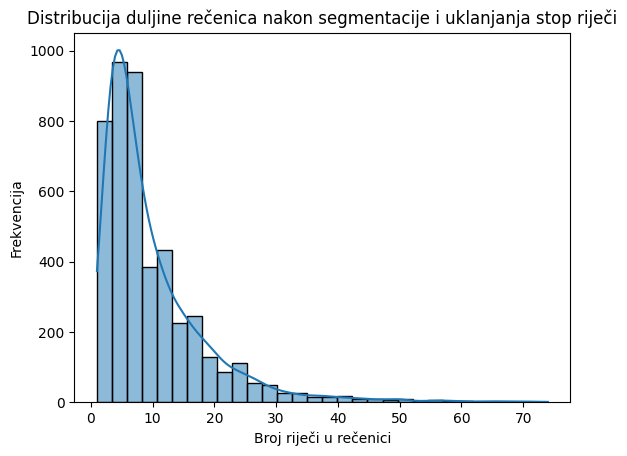

In [ ]:
# Vizualizacija distribucije duljine rečenica
sns.histplot(sentence_lengths, bins=30, kde=True)
plt.xlabel("Broj riječi u rečenici")
plt.ylabel("Frekvencija")
plt.title("Distribucija duljine rečenica nakon segmentacije i uklanjanja stop riječi")
plt.show()

Iz dobivenog grafa možemo zaključiti da većina rečenica ima manji broj riječi (od 5 do 10). Kako broj riječi raste, učestalost rečenica opada. *Dugi rep* distrubije nam govori da postoji nekoliko vrlo dugih rečenica, ali su jako rijetke.

**2. Primjena CRF modela za označavanje granica rečenica**

**CRF (Conditional Random Field)** je model temeljen na strojnom učenju koji se koristi za sekvencijalne zadatke poput segmentacije teksta, označavanja entiteta (Named Entity Recognition - NER), ili tagginga u prirodnom jeziku. CRF je grafički model koji koristi vjerojatnost za predviđanje izlaza na temelju uvjeta na prethodnim i sljedećim vrijednostima (tj. uzima u obzir okolni kontekst).

Kod segmentacije rečenica, CRF model se koristi za predviđanje granica rečenica na temelju okolnih riječi i njihovih svojstava.

In [ ]:
#CRF

# Ekstrakcija obilježja iz rečenica(riječ, pozicija riječi (prva/posljednja), ima li veliko početno slovo, duljina riječi) za prepoznavanje granica rečenica
def extract_features(sentence):
    features = []
    for i in range(len(sentence)):
        word = sentence[i]
        features.append({
            'word': word,
            'is_first': i == 0,
            'is_last': i == len(sentence) - 1,
            'is_capitalized': word[0].upper() == word[0],
            'word_length': len(word)
        })
    return features

# Kreiranje oznaka koje označavaju kraj rečenice ili nastavak
def create_labels(sentence):
    labels = []
    for i in range(len(sentence)):
        if sentence[i][-1] == "." or sentence[i][-1] == "!" or sentence[i][-1] == "?":
            labels.append("SENT_END")
        else:
            labels.append("SENT_CONT")
    return labels

X_crf = [extract_features(sentence.split()) for sentence in filtered_sentences]
y_crf = [create_labels(sentence.split()) for sentence in filtered_sentences]

# Ispis skupa obilježja i oznaka za prvu rečenicu
print(X_crf[0], y_crf[0])

[{'word': 'Jutro', 'is_first': True, 'is_last': False, 'is_capitalized': True, 'word_length': 5}, {'word': ',', 'is_first': False, 'is_last': False, 'is_capitalized': True, 'word_length': 1}, {'word': 'kobnog', 'is_first': False, 'is_last': False, 'is_capitalized': False, 'word_length': 6}, {'word': 'objašnjenja', 'is_first': False, 'is_last': False, 'is_capitalized': False, 'word_length': 11}, {'word': 'Petra', 'is_first': False, 'is_last': False, 'is_capitalized': True, 'word_length': 5}, {'word': 'Petroviča', 'is_first': False, 'is_last': False, 'is_capitalized': True, 'word_length': 9}, {'word': 'Dunječkom', 'is_first': False, 'is_last': False, 'is_capitalized': True, 'word_length': 9}, {'word': 'Puljherijom', 'is_first': False, 'is_last': False, 'is_capitalized': True, 'word_length': 11}, {'word': 'Aleksandrovnom', 'is_first': False, 'is_last': False, 'is_capitalized': True, 'word_length': 14}, {'word': ',', 'is_first': False, 'is_last': False, 'is_capitalized': True, 'word_length

In [ ]:
X_crf_train, X_crf_test, y_crf_train, y_crf_test = train_test_split(X_crf, y_crf, test_size=0.3, random_state=42)

# Inicijalizacija CRF modela s parametrima:
# - algorithm='lbfgs' - Algoritam optimizacije (BFGS) za optimizaciju modela
# - c1 i c2 - L2 regularizacija za sprječavanje prekomjernog prilagođavanja modela
# - max_iterations=100 - Maksimalni broj iteracija za treniranje modela
crf = sklearn_crfsuite.CRF(algorithm='lbfgs', c1=0.1, c2=0.1, max_iterations=100)

crf.fit(X_crf_train, y_crf_train)

y_crf_pred = crf.predict(X_crf_test)

y_crf_test_flat = [label for sentence in y_crf_test for label in sentence]
y_crf_pred_flat = [label for sentence in y_crf_pred for label in sentence]

print("Evaluacija modela:")
print(classification_report(y_crf_test_flat, y_crf_pred_flat))

accuracy = accuracy_score(y_crf_test_flat, y_crf_pred_flat)
print(f"Točnost modela: {accuracy:.4f}")

errors = [1 if y_crf_pred_flat[i] != y_crf_test_flat[i] else 0 for i in range(len(y_crf_pred_flat))]
print(f"Broj pogrešaka: {sum(errors)}")

Evaluacija modela:
              precision    recall  f1-score   support

   SENT_CONT       1.00      1.00      1.00     12368
    SENT_END       1.00      1.00      1.00      1380

    accuracy                           1.00     13748
   macro avg       1.00      1.00      1.00     13748
weighted avg       1.00      1.00      1.00     13748

Točnost modela: 0.9997
Broj pogrešaka: 4


CRF model pokazao je izuzetnu točnost od 99.97% u prepoznavanju granica rečenica, s minimalnim brojem pogrešaka. Ovi rezultati potvrđuju da je model vrlo pouzdan i učinkovit za zadatak segmentacije teksta.

**3. Primjena modela stabla odluke za prepoznavanje krajeva rečenica na temelju jednostavnih obilježja riječi**

Model stabla odluke služi za prepoznavanje granica rečenica, tj. određuje završava li riječ rečenicu ili ne. To je ključno za obradu prirodnog jezika, jer pravilna segmentacija rečenica utječe na mnoge zadatke poput: strojne obrade teksta (npr. analiza sentimenta, sažimanje teksta), prepoznavanja entiteta (NER – Named Entity Recognition) te pretraživanja i ekstrakcije informacija. Model predviđa interpunkcijske znakove (., !, ?) na temelju karakteristika riječi.


In [ ]:
# Stablo odluke

# ekstrakcija značajki iz teksta
def extract_features(text):
    features = []
    labels = []

    words = nltk.word_tokenize(text) # razbijanje teksta na pojedinačne riječi
    for i in range(len(words) - 1):
        word = words[i]
        next_word = words[i + 1]

        feature_vector = {
            "word_length": len(word), # duljina trenutne riječi?
            "next_word_length": len(next_word), # duljina sljedeće riječi?
            "is_upper": word[0].isupper(), # prva slova trenutne riječi veliko?
            "next_is_upper": next_word[0].isupper(), # prvo slovo sljedeće riječi veliko?
            "is_punctuation": word in ['.', '!', '?'], # trenutna riječ znak interpunkcije?
        }

        features.append(feature_vector)
        labels.append(1 if word in ['.', '!', '?'] else 0) #  postavlja oznaku 1 ako je riječ interpunkcijski znak, inače 0

    return features, labels


features, labels = extract_features(podaci)
X_clf = pd.DataFrame(features)
y_clf = np.array(labels)

In [ ]:
X_clf_train, X_clf_test, y_clf_train, y_clf_test = train_test_split(X_clf, y_clf, test_size=0.2, random_state=42)

clf = DecisionTreeClassifier()
clf.fit(X_clf, y_clf)

y_clf_pred = clf.predict(X_clf_test)
accuracy = accuracy_score(y_clf_test, y_clf_pred)
conf_matrix = confusion_matrix(y_clf_test, y_clf_pred)
num_errors = conf_matrix[0][1] + conf_matrix[1][0]

print("Evaluacija modela:\n", classification_report(y_clf_test, y_clf_pred))
print("Točnost modela:", accuracy)
print("Broj pogrešaka:", num_errors)

Evaluacija modela:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00     13648
           1       1.00      1.00      1.00       901

    accuracy                           1.00     14549
   macro avg       1.00      1.00      1.00     14549
weighted avg       1.00      1.00      1.00     14549

Tocnost: 1.0
Broj pogresaka: 0


Model stabla odluke postigao je 100% točnost, bez pogreške u prepoznavanju granica rečenica. Ovi rezultati ukazuju na savršenu prilagodbu modela podacima, što može značiti visoku učinkovitost, ali i mogućnost preprilagođenosti (overfitting).

**4. GRU (Gated Recurrent Unit)**

 GRU je vrsta rekurentne neuronske mreže (RNN) koja je dizajnirana kako bi riješila problem gubitka dugoročnog pamćenja kod klasičnih RNN-ova. GRU koristi dva glavna "gated" (kontrolna) mehanizma koji reguliraju kako informacije teku kroz mrežu: Reset Gate (Resetirajuća vrata) i Update Gate (Ažurirajuća vrata). Resetirajuća vrata dređuje koliko prethodnih informacija treba zaboraviti (ako je reset gate blizu nule, mreža zanemaruje starije podatke). Ažurirajuća vrata kontroliraju koliko novih informacija treba sačuvati, a koliko starih informacija treba zadržati (ako je update gate blizu nule, mreža čuva stare informacije i ne ažurira ih; ako je update gate blizu jedinice, mreža u potpunosti zamjenjuje stare informacije novima).

In [ ]:
#GRU
# segmentirane i očišćene rečenice
sentences = [sentence.split() for sentence in filtered_sentences]

# Kreiranje oznaka: "SENT_END" za kraj rečenice, ostalo "SENT_CONT"
labels = []
for sentence in sentences:
    sent_labels = ["SENT_CONT"] * len(sentence)
    sent_labels[-1] = "SENT_END"
    labels.append(sent_labels)

# Tokenizacija riječi (pretvaranje u brojeve)
tokenizer = tf.keras.preprocessing.text.Tokenizer()
tokenizer.fit_on_texts(sentences)
X_gru = tokenizer.texts_to_sequences(sentences)

# Tokenizacija oznaka (SENT_CONT = 0, SENT_END = 1)
label_dict = {"SENT_CONT": 0, "SENT_END": 1}
y_gru = [[label_dict[label] for label in sent] for sent in labels]

# Padding sekvenci (poravnanje duljine rečenica)
max_len = max(len(sentence) for sentence in X_gru)
X_gru_padded = pad_sequences(X_gru, maxlen=max_len, padding='post')
y_gru_padded = pad_sequences(y_gru, maxlen=max_len, padding='post')

# One-hot encoding za oznake (potrebno za neuronske mreže)
y_gru_padded = to_categorical(y_gru_padded, num_classes=2)

In [ ]:
X_gru_train, X_gru_test, y_gru_train, y_gru_test = train_test_split(X_gru_padded, y_gru_padded, test_size=0.2, random_state=42)

gru = Sequential([
    Embedding(input_dim=len(tokenizer.word_index) + 1, output_dim=64, input_length=max_len),
    GRU(64, return_sequences=True),  # GRU sloj
    Dropout(0.5),
    TimeDistributed(Dense(2, activation='softmax'))  # Softmax aktivacija za 2 klase: SENT_CONT i SENT_END
])

gru.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
gru.fit(X_gru_train, y_gru_train, batch_size=32, epochs=5, validation_data=(X_gru_test, y_gru_test))

y_gru_pred = gru.predict(X_gru_test)
y_gru_pred_classes = np.argmax(y_gru_pred, axis=-1)
y_gru_test_classes = np.argmax(y_gru_test, axis=-1)

y_gru_test_flat = y_gru_test_classes.flatten()
y_gru_pred_flat = y_gru_pred_classes.flatten()

print("Evaluacija modela:")
print(classification_report(y_gru_test_flat, y_gru_pred_flat))

accuracy = accuracy_score(y_gru_test_flat, y_gru_pred_flat)
print(f"Točnost modela: {accuracy:.4f}")

Epoch 1/5


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


115/115 ━━━━━━━━━━━━━━━━━━━━ 33s 146ms/step - accuracy: 0.9834 - loss: 0.1201 - val_accuracy: 1.0000 - val_loss: 0.0061
Epoch 2/5
115/115 ━━━━━━━━━━━━━━━━━━━━ 20s 139ms/step - accuracy: 1.0000 - loss: 0.0044 - val_accuracy: 1.0000 - val_loss: 0.0024
Epoch 3/5
115/115 ━━━━━━━━━━━━━━━━━━━━ 16s 98ms/step - accuracy: 1.0000 - loss: 0.0017 - val_accuracy: 1.0000 - val_loss: 0.0015
Epoch 4/5
115/115 ━━━━━━━━━━━━━━━━━━━━ 29s 169ms/step - accuracy: 1.0000 - loss: 8.0690e-04 - val_accuracy: 1.0000 - val_loss: 0.0011
Epoch 5/5
115/115 ━━━━━━━━━━━━━━━━━━━━ 10s 79ms/step - accuracy: 1.0000 - loss: 4.7727e-04 - val_accuracy: 1.0000 - val_loss: 8.4681e-04
29/29 ━━━━━━━━━━━━━━━━━━━━ 3s 68ms/step
Evaluacija modela:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     66941
           1       1.00      1.00      1.00       917

    accuracy                           1.00     67858
   macro avg       1.00      1.00      1.00     67858
weighted avg       

Model je treniran kroz 5 epoha, a evaluacija pokazuje savršene rezultate (100% točnost). Accuracy počinje na 95.78% u prvoj epohi i brzo doseže 100%. loss počinje na 0.1222 i pada na 0.00046, što znači da je model savršeno naučio obrasce. Validacijski gubitak opada, što znači da nema prenaučenosti.

## **Zaključak**

U projektu su korištene tri metode za segmentaciju rečenica: CRF, CLF i GRU (neuronska mreža). Na temelju dobivenih rezultata, zaključujemo sljedeće:

*   CRF model postigao je gotovo savršenu točnost od 99.97%, uz minimalan broj pogrešaka (samo 4 pogrešna predviđanja), što ga čini vrlo pouzdanim za ovu vrstu zadatka.
*   CLF model ostvario je 100% točnost, ali to može ukazivati na preprilagodbu (overfitting), budući da model savršeno predviđa podatke na kojima je treniran.
*   GRU model, kao duboka neuronska mreža, također je postigao 100% točnost, s vrlo niskom vrijednošću gubitka (loss < 0.001 na kraju treninga), što pokazuje da je model savršeno naučio obrasce u podacima bez prenaučenosti.

Svi modeli su izuzetno precizni, ali CRF se čini najpraktičnijim izborom zbog svoje sposobnosti da se dobro generalizira na podatke, bez preprilagodbe.
Modele ćemo dodatno testirati na novim podacima kako bismo potvrdili njihovu robusnost i učinkovitost.

## **Testiranje na novim podacima**

In [ ]:
# Učitavanje podataka
with open('/content/drive/My Drive/projekt_nlp/podaci2.txt', 'r') as f:
  podaci2 = f.read()
podaci2 = re.sub(r'[\n\r\xad\t\u200B\u200C\u00A0\s]+', ' ', podaci2)
podaci2 = re.sub(r'[^\x20-\x7E]', '', podaci2)
podaci2

"Fjodor Pavlovi Karamazov Aleksej Fjodorovi Karamazov bio je trei sin Fjodora Pavlovia Karamazova, vlastelina u naem kotaru, toliko uvena u svoje vrijeme (a i danas ga jo kod nas spominju) zbog svoje tragine i zagonetne smrti, od koje je proteklo punih trinaest godina i o kojoj u priati na svome mjestu. A sad u rei o tom vlastelinu, kako su ga kod nas zvali (iako nije gotovo nikad cijelog ivota ivio na svom dobru), tek toliko, da je to bio neobian tip, s kakvim se ipak dosta esto susreemo, to jest, tip ovjeka ne samo prljava i razvrat na, nego ujedno i smuena  ali ipak od onih smuenjaka, koji umiju izvrsno da vode svoje imovinske sitne poslove i, ini se, nita drugo. Fjodor Pavlovi, na primjer, otpoeo je gotovo bez iega, bio je jedan od najsitnijih vlastelina, oblizivao se oko tuih stolova, gledao je da ivi na tui raun, a meutim, u asu njegove smrti nalo se u njega do sto tinu tisua rubalja gotova novca. I istovremeno bio je ipak cijeloga svog ivota jedan od najsmuenijih budala u naem o

In [ ]:
# Segmentacija i čišćenje rečenica
recenice2 = ocisti_segmentiraj(podaci2)

In [ ]:
# Uklanjanje stop riječi iz svake rečenice
filtered_sentences2 = []
for recenica in recenice2:
    words2 = word_tokenize(recenica)
    filtered_sentence2 = " ".join([word for word in words2 if word.lower() not in stop])
    filtered_sentences2.append(filtered_sentence2)

In [ ]:
print(f"Ukupan broj segmentiranih rečenica: {len(filtered_sentences2)}")
sentence_lengths2 = [len(s.split()) for s in filtered_sentences2]

Ukupan broj segmentiranih rečenica: 20390


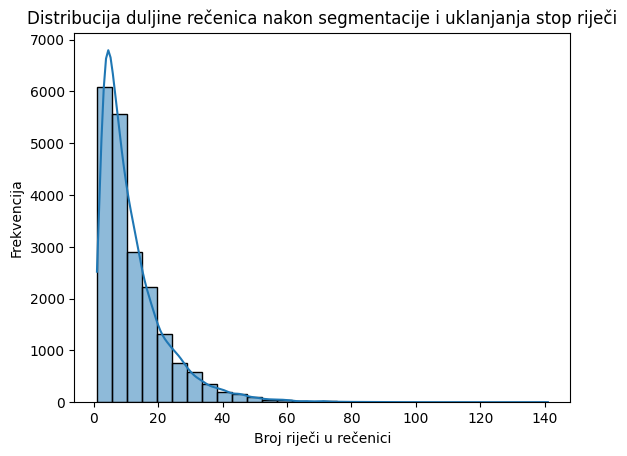

In [ ]:
# Vizualizacija distribucije duljine rečenica
sns.histplot(sentence_lengths2, bins=30, kde=True)
plt.xlabel("Broj riječi u rečenici")
plt.ylabel("Frekvencija")
plt.title("Distribucija duljine rečenica nakon segmentacije i uklanjanja stop riječi")
plt.show()

In [ ]:
# CRF
X2_crf_features = [extract_features(sentence) for sentence in filtered_sentences2]
X2_crf_features = [features for features, _ in X2_crf_features]  # Uzimamo samo features

vectorizer = DictVectorizer(sparse=False)
X2_crf = vectorizer.fit_transform([feat for sentence in X2_crf_features for feat in sentence])
X2_crf = np.array(X2_crf)

# Predikcija modela na novim podacima
y2_crf_pred_new = crf.predict(X2_crf)

y2_crf_test_new_flat = [label for sentence in y2_crf_pred_new for label in sentence]
y2_crf_pred_new_flat = [label for sentence in y2_crf_pred_new for label in sentence]

print("Evaluacija modela:")
print(classification_report(y2_crf_test_new_flat, y2_crf_pred_new_flat))

accuracy = accuracy_score(y2_crf_test_new_flat, y2_crf_pred_new_flat)
print(f"Točnost modela: {accuracy:.4f}")

errors = [1 if y2_crf_pred_new_flat[i] != y2_crf_test_new_flat[i] else 0 for i in range(len(y2_crf_pred_new_flat))]
print(f"Broj pogrešaka: {sum(errors)}")

Evaluacija modela:
              precision    recall  f1-score   support

   SENT_CONT       1.00      1.00      1.00   1139015

    accuracy                           1.00   1139015
   macro avg       1.00      1.00      1.00   1139015
weighted avg       1.00      1.00      1.00   1139015

Točnost modela: 1.0000
Broj pogrešaka: 0


In [ ]:
# Stablo odluke
features, labels = extract_features(podaci2)

X2_clf = pd.DataFrame(features)
y2_clf = np.array(labels)

y2_clf_pred = clf.predict(X2_clf)

accuracy = accuracy_score(y2_clf, y2_clf_pred)
conf_matrix = confusion_matrix(y2_clf, y2_clf_pred)
num_errors = conf_matrix[0][1] + conf_matrix[1][0]

print("Evaluacija modela:\n", classification_report(y2_clf, y2_clf_pred))
print("Točnost modela:", accuracy)
print("Broj pogrešaka:", num_errors)

Evaluacija modela:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00    378469
           1       1.00      1.00      1.00     20292

    accuracy                           1.00    398761
   macro avg       1.00      1.00      1.00    398761
weighted avg       1.00      1.00      1.00    398761

Točnost na podacima: 1.0
Broj pogrešaka na podacima: 0


In [ ]:
# GRU
filtered_sentences = ocisti_segmentiraj(podaci2)
sentences = [sentence.split() for sentence in filtered_sentences2]

labels = []
for sentence in sentences:
    sent_labels = ["SENT_CONT"] * len(sentence)
    sent_labels[-1] = "SENT_END"
    labels.append(sent_labels)

# Tokenizacija za nove podatke koristeći isti tokenizer kao za treniranje
X2_gru = tokenizer.texts_to_sequences(sentences)

label_dict = {"SENT_CONT": 0, "SENT_END": 1}
y2_gru = [[label_dict[label] for label in sent] for sent in labels]

max_len = max(len(sentence) for sentence in X2_gru)
X2_gru_padded = pad_sequences(X2_gru, maxlen=max_len, padding='post')
y2_gru_padded = pad_sequences(y2_gru, maxlen=max_len, padding='post')

y2_gru_padded = to_categorical(y2_gru_padded, num_classes=2)

y2_gru_pred = gru.predict(X2_gru_padded)
y2_gru_pred_classes = np.argmax(y2_gru_pred, axis=-1)
y2_gru_test_classes = np.argmax(y2_gru_padded, axis=-1)

y2_gru_test_flat = y2_gru_test_classes.flatten()
y2_gru_pred_flat = y2_gru_pred_classes.flatten()

print("Evaluacija modela:")
print(classification_report(y2_gru_test_flat, y2_gru_pred_flat))

accuracy = accuracy_score(y2_gru_test_flat, y2_gru_pred_flat)
print(f"Točnost modela: {accuracy:.4f}")

638/638 ━━━━━━━━━━━━━━━━━━━━ 12s 18ms/step
Evaluacija modela:
              precision    recall  f1-score   support

           0       0.99      0.99      0.99   1610810
           1       0.09      0.09      0.09     20390

    accuracy                           0.98   1631200
   macro avg       0.54      0.54      0.54   1631200
weighted avg       0.98      0.98      0.98   1631200

Točnost modela: 0.9772


## **Zaključak**

Na temelju evaluacije svih modela na novim podacima, možemo zaključiti:


*   CRF model postigao je 100% točnost na novim podacima, što ukazuje na njegovu preciznost i sposobnost generaliziranja. Model nije imao nijednu pogrešku, što sugerira da je vrlo stabilan i pouzdan, te je najpraktičniji izbor za zadatak segmentacije rečenica.

*   CLF model također je postigao 100% točnost na novim podacima, što znači da nema overfittinga.

*   GRU model ostvario je točnost od 97.72%. Iako to još uvijek predstavlja vrlo visoku točnost, performanse modela su lošije za klasu "SENT_END" (samo 0.09% precision i recall za tu klasu), što znači da model nije naučio prepoznati krajeve rečenica. Model pokazuje probleme u prepoznavanju manjinskih klasa, što može biti rezultat neizbalansiranih podataka ili potrebe za dodatnom optimizacijom.